# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/ensemble/unetr"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/ensemble/unetr


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"data/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR09fold2.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                       | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 172, 193]), label shape: torch.Size([1, 250, 172, 193])


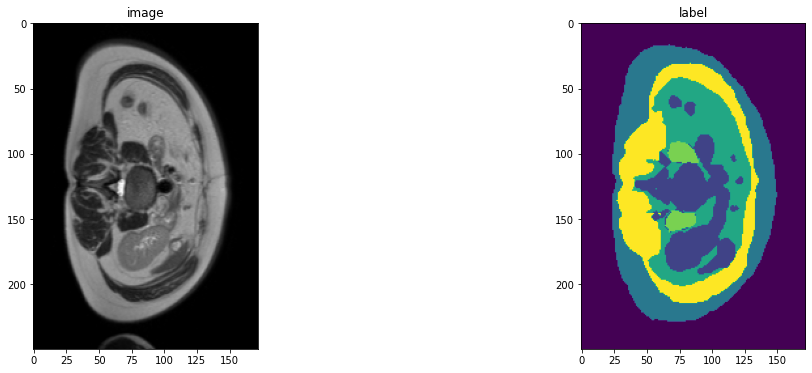

In [7]:
slice_map = {
    "A037_v1_T2W.nii.gz": 10,
    "A037_v1_T2W.nii.gz": 8,
    "A037_v1_T2W.nii.gz": 6
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR10_swinUNetR_fold2.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold2.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=1.77650):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5815723737080892 Current Avg. Dice: 0.5815723737080892


Training (500 / 70000 Steps) (loss=1.72053):  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6193366249402364 Current Avg. Dice: 0.6193366249402364


Training (750 / 70000 Steps) (loss=1.28467):  58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6193366249402364 Current Avg. Dice: 0.5868964592615763


Training (1000 / 70000 Steps) (loss=1.17599):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6193366249402364 Current Avg. Dice: 0.5776589115460714


Training (1250 / 70000 Steps) (loss=1.06395):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:31,  3.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6193366249402364 Current Avg. Dice: 0.6087067325909933


Training (1500 / 70000 Steps) (loss=0.97697):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:20,  7.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6420088013013204 Current Avg. Dice: 0.6420088013013204


Training (1750 / 70000 Steps) (loss=0.90426):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6743649045626322 Current Avg. Dice: 0.6743649045626322


Training (2000 / 70000 Steps) (loss=0.82263):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6992515722910563 Current Avg. Dice: 0.6992515722910563


Training (2250 / 70000 Steps) (loss=0.71671):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6992515722910563 Current Avg. Dice: 0.6799797018369039


Training (2500 / 70000 Steps) (loss=0.59148):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7098424832026163 Current Avg. Dice: 0.7098424832026163


Training (2750 / 70000 Steps) (loss=0.76489):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:32,  3.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7221527298291525 Current Avg. Dice: 0.7221527298291525


Training (3000 / 70000 Steps) (loss=0.92385):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:17,  7.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7221527298291525 Current Avg. Dice: 0.7153448065121969


Training (3250 / 70000 Steps) (loss=0.74149):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7221527298291525 Current Avg. Dice: 0.7168908516565958


Training (3500 / 70000 Steps) (loss=0.69178):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.62s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7304360071818033 Current Avg. Dice: 0.7304360071818033


Training (3750 / 70000 Steps) (loss=0.70668):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7304360071818033 Current Avg. Dice: 0.7181733647982279


Training (4000 / 70000 Steps) (loss=0.72640):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7314495245615641 Current Avg. Dice: 0.7314495245615641


Training (4250 / 70000 Steps) (loss=0.63996):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7314495245615641 Current Avg. Dice: 0.7208147644996643


Training (4500 / 70000 Steps) (loss=0.73461):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:21,  7.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7388103604316711 Current Avg. Dice: 0.7388103604316711


Training (4750 / 70000 Steps) (loss=0.49395):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7713043093681335 Current Avg. Dice: 0.7713043093681335


Training (5000 / 70000 Steps) (loss=0.64600):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8086438576380411 Current Avg. Dice: 0.8086438576380411


Training (5250 / 70000 Steps) (loss=0.70836):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8277903000513712 Current Avg. Dice: 0.8277903000513712


Training (5500 / 70000 Steps) (loss=0.61073):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8602727254231771 Current Avg. Dice: 0.8602727254231771


Training (5750 / 70000 Steps) (loss=0.58953):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8602727254231771 Current Avg. Dice: 0.8573564489682516


Training (6000 / 70000 Steps) (loss=0.47886):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:20,  7.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8602727254231771 Current Avg. Dice: 0.8530105551083883


Training (6250 / 70000 Steps) (loss=0.44605):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8756669362386068 Current Avg. Dice: 0.8756669362386068


Training (6500 / 70000 Steps) (loss=0.55754):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8756669362386068 Current Avg. Dice: 0.8643761078516642


Training (6750 / 70000 Steps) (loss=0.46721):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8758450547854105 Current Avg. Dice: 0.8758450547854105


Training (7000 / 70000 Steps) (loss=0.53041):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8758450547854105 Current Avg. Dice: 0.8641207019488016


Training (7250 / 70000 Steps) (loss=0.72235):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:32,  3.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8758450547854105 Current Avg. Dice: 0.8689663807551066


Training (7500 / 70000 Steps) (loss=0.46982):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:21,  7.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8758450547854105 Current Avg. Dice: 0.8657331665356954


Training (7750 / 70000 Steps) (loss=0.36126):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8758450547854105 Current Avg. Dice: 0.8733141819636027


Training (8000 / 70000 Steps) (loss=0.36804):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8880035678545634 Current Avg. Dice: 0.8880035678545634


Training (8250 / 70000 Steps) (loss=0.46688):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8885822892189026 Current Avg. Dice: 0.8885822892189026


Training (8500 / 70000 Steps) (loss=0.39531):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8885822892189026 Current Avg. Dice: 0.881726066271464


Training (8750 / 70000 Steps) (loss=0.41712):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:33,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8885822892189026 Current Avg. Dice: 0.8860824902852377


Training (9000 / 70000 Steps) (loss=0.58172):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:22,  7.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8890968362490336 Current Avg. Dice: 0.8890968362490336


Training (9250 / 70000 Steps) (loss=0.36382):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8890968362490336 Current Avg. Dice: 0.8835545579592387


Training (9500 / 70000 Steps) (loss=0.53318):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8918365041414896 Current Avg. Dice: 0.8918365041414896


Training (9750 / 70000 Steps) (loss=0.47233):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:13,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8918365041414896 Current Avg. Dice: 0.8907037178675333


Training (10000 / 70000 Steps) (loss=0.38487):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8918365041414896 Current Avg. Dice: 0.8768003582954407


Training (10250 / 70000 Steps) (loss=0.33771):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8927738070487976 Current Avg. Dice: 0.8927738070487976


Training (10500 / 70000 Steps) (loss=0.44689):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8927738070487976 Current Avg. Dice: 0.8869096636772156


Training (10750 / 70000 Steps) (loss=0.59270):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8983197013537089


Training (11000 / 70000 Steps) (loss=0.41724):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8895504474639893


Training (11250 / 70000 Steps) (loss=0.38843):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8956226309140524


Training (11500 / 70000 Steps) (loss=0.39217):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8924240668614706


Training (11750 / 70000 Steps) (loss=0.36621):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8980855147043864


Training (12000 / 70000 Steps) (loss=0.30131):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:17,  7.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8943988084793091


Training (12250 / 70000 Steps) (loss=0.38886):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8956469893455505


Training (12500 / 70000 Steps) (loss=0.45302):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8974297444025675


Training (12750 / 70000 Steps) (loss=0.46721):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.895216166973114


Training (13000 / 70000 Steps) (loss=0.36668):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8967206080754598


Training (13250 / 70000 Steps) (loss=0.35914):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8983197013537089 Current Avg. Dice: 0.8953015208244324


Training (13500 / 70000 Steps) (loss=0.39779):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9009620547294617 Current Avg. Dice: 0.9009620547294617


Training (13750 / 70000 Steps) (loss=0.32372):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9009620547294617 Current Avg. Dice: 0.896790345509847


Training (14000 / 70000 Steps) (loss=0.31489):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.902452270189921 Current Avg. Dice: 0.902452270189921


Training (14250 / 70000 Steps) (loss=0.29182):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902452270189921 Current Avg. Dice: 0.8991325894991556


Training (14500 / 70000 Steps) (loss=0.42488):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902452270189921 Current Avg. Dice: 0.9022172490755717


Training (14750 / 70000 Steps) (loss=0.34564):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902452270189921 Current Avg. Dice: 0.8955093622207642


Training (15000 / 70000 Steps) (loss=0.34837):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9040850202242533 Current Avg. Dice: 0.9040850202242533


Training (15250 / 70000 Steps) (loss=0.38722):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9040850202242533 Current Avg. Dice: 0.8959036866823832


Training (15500 / 70000 Steps) (loss=0.31518):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9076812863349915


Training (15750 / 70000 Steps) (loss=0.33048):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9037025372187296


Training (16000 / 70000 Steps) (loss=0.30541):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.8986237645149231


Training (16250 / 70000 Steps) (loss=0.32167):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.8984761238098145


Training (16500 / 70000 Steps) (loss=0.37148):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9043036500612894


Training (16750 / 70000 Steps) (loss=0.41854):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9072908560434977


Training (17000 / 70000 Steps) (loss=0.37785):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9039017558097839


Training (17250 / 70000 Steps) (loss=0.36762):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9036186933517456


Training (17500 / 70000 Steps) (loss=0.32825):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9048224886258444


Training (17750 / 70000 Steps) (loss=0.23007):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9062570730845133


Training (18000 / 70000 Steps) (loss=0.22950):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9065666000048319


Training (18250 / 70000 Steps) (loss=0.47648):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9046317934989929


Training (18500 / 70000 Steps) (loss=0.33120):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9056140780448914


Training (18750 / 70000 Steps) (loss=0.26588):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:13,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9022777875264486


Training (19000 / 70000 Steps) (loss=0.29326):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.8986242214838663


Training (19250 / 70000 Steps) (loss=0.33319):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9016474684079488


Training (19500 / 70000 Steps) (loss=0.44117):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9019818902015686


Training (19750 / 70000 Steps) (loss=0.39801):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9065853754679362


Training (20000 / 70000 Steps) (loss=0.29535):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.8950119813283285


Training (20250 / 70000 Steps) (loss=0.28918):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:13,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.904070238272349


Training (20500 / 70000 Steps) (loss=0.49340):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9076812863349915 Current Avg. Dice: 0.9053973952929179


Training (20750 / 70000 Steps) (loss=0.39884):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.908330241839091 Current Avg. Dice: 0.908330241839091


Training (21000 / 70000 Steps) (loss=0.25851):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.908330241839091 Current Avg. Dice: 0.9040597081184387


Training (21250 / 70000 Steps) (loss=0.46219):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.908330241839091 Current Avg. Dice: 0.9004520376523336


Training (21500 / 70000 Steps) (loss=0.32119):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9083964824676514 Current Avg. Dice: 0.9083964824676514


Training (21750 / 70000 Steps) (loss=0.32489):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9083964824676514 Current Avg. Dice: 0.8942157427469889


Training (22000 / 70000 Steps) (loss=0.27482):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9083964824676514 Current Avg. Dice: 0.9040893117586771


Training (22250 / 70000 Steps) (loss=0.32555):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9093807538350424 Current Avg. Dice: 0.9093807538350424


Training (22500 / 70000 Steps) (loss=0.29656):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9093807538350424 Current Avg. Dice: 0.8793140848477682


Training (22750 / 70000 Steps) (loss=0.36035):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9093807538350424 Current Avg. Dice: 0.9090175827344259


Training (23000 / 70000 Steps) (loss=0.32758):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9093807538350424 Current Avg. Dice: 0.9080162843068441


Training (23250 / 70000 Steps) (loss=0.26085):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9126620491345724


Training (23500 / 70000 Steps) (loss=0.39431):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9081491629282633


Training (23750 / 70000 Steps) (loss=0.33835):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9082886377970377


Training (24000 / 70000 Steps) (loss=0.25462):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9065213998158773


Training (24250 / 70000 Steps) (loss=0.36246):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9086342453956604


Training (24500 / 70000 Steps) (loss=0.26704):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9091282288233439


Training (24750 / 70000 Steps) (loss=0.37434):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9043848315874735


Training (25000 / 70000 Steps) (loss=0.33306):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9109020034472147


Training (25250 / 70000 Steps) (loss=0.27700):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9065787593523661


Training (25500 / 70000 Steps) (loss=0.30080):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:17,  7.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126620491345724 Current Avg. Dice: 0.9094911416371664


Training (25750 / 70000 Steps) (loss=0.25817):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9126791755358378


Training (26000 / 70000 Steps) (loss=0.24166):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9049827853838602


Training (26250 / 70000 Steps) (loss=0.37819):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9114054441452026


Training (26500 / 70000 Steps) (loss=0.24621):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9115476012229919


Training (26750 / 70000 Steps) (loss=0.25669):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9047485589981079


Training (27000 / 70000 Steps) (loss=0.28274):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9096651474634806


Training (27250 / 70000 Steps) (loss=0.48398):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9101213415463766


Training (27500 / 70000 Steps) (loss=0.28551):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9126199881235758


Training (27750 / 70000 Steps) (loss=0.33628):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:13,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9104677438735962


Training (28000 / 70000 Steps) (loss=0.34993):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9056428273518881


Training (28250 / 70000 Steps) (loss=0.22466):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.908523440361023


Training (28500 / 70000 Steps) (loss=0.31643):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9091688990592957


Training (28750 / 70000 Steps) (loss=0.26287):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9095356861750284


Training (29000 / 70000 Steps) (loss=0.32101):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9053874413172404


Training (29250 / 70000 Steps) (loss=0.27553):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9125856558481852


Training (29500 / 70000 Steps) (loss=0.30207):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9073985815048218


Training (29750 / 70000 Steps) (loss=0.27076):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9095449447631836


Training (30000 / 70000 Steps) (loss=0.29900):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9067345062891642


Training (30250 / 70000 Steps) (loss=0.24567):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9085175196329752


Training (30500 / 70000 Steps) (loss=0.22393):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:07,  2.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9117907881736755


Training (30750 / 70000 Steps) (loss=0.27854):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9113308389981588


Training (31000 / 70000 Steps) (loss=0.44036):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.904413084189097


Training (31250 / 70000 Steps) (loss=0.29334):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:32,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126791755358378 Current Avg. Dice: 0.9115276336669922


Training (31500 / 70000 Steps) (loss=0.27222):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9134367307027181


Training (31750 / 70000 Steps) (loss=0.26992):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.909356156984965


Training (32000 / 70000 Steps) (loss=0.40928):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9122955401738485


Training (32250 / 70000 Steps) (loss=0.29479):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9096761544545492


Training (32500 / 70000 Steps) (loss=0.41816):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9103929797808329


Training (32750 / 70000 Steps) (loss=0.26176):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9122319420178732


Training (33000 / 70000 Steps) (loss=0.32172):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.908395787080129


Training (33250 / 70000 Steps) (loss=0.42180):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9114893873532613


Training (33500 / 70000 Steps) (loss=0.44010):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9115991791089376


Training (33750 / 70000 Steps) (loss=0.33319):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9103968540827433


Training (34000 / 70000 Steps) (loss=0.46436):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9122872352600098


Training (34250 / 70000 Steps) (loss=0.37443):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9095725814501444


Training (34500 / 70000 Steps) (loss=0.30246):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9105706810951233


Training (34750 / 70000 Steps) (loss=0.27869):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9108230074246725


Training (35000 / 70000 Steps) (loss=0.32478):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9118948578834534


Training (35250 / 70000 Steps) (loss=0.31524):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9127236008644104


Training (35500 / 70000 Steps) (loss=0.23486):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9101144075393677


Training (35750 / 70000 Steps) (loss=0.26319):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9095754623413086


Training (36000 / 70000 Steps) (loss=0.26968):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9101301829020182


Training (36250 / 70000 Steps) (loss=0.27046):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9064874053001404


Training (36500 / 70000 Steps) (loss=0.23715):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9134367307027181 Current Avg. Dice: 0.9070330659548441


Training (36750 / 70000 Steps) (loss=0.30431):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:13,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9139226675033569


Training (37000 / 70000 Steps) (loss=0.31029):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9066303571065267


Training (37250 / 70000 Steps) (loss=0.39368):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9112541476885477


Training (37500 / 70000 Steps) (loss=0.23957):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.909846822420756


Training (37750 / 70000 Steps) (loss=0.31158):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9105578462282816


Training (38000 / 70000 Steps) (loss=0.20941):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9104187289873759


Training (38250 / 70000 Steps) (loss=0.39555):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9108673731486002


Training (38500 / 70000 Steps) (loss=0.31351):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9089236855506897


Training (38750 / 70000 Steps) (loss=0.31167):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9126425782839457


Training (39000 / 70000 Steps) (loss=0.27870):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.913066029548645


Training (39250 / 70000 Steps) (loss=0.38557):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9120420614878336


Training (39500 / 70000 Steps) (loss=0.38163):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9134212732315063


Training (39750 / 70000 Steps) (loss=0.13765):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9139226675033569 Current Avg. Dice: 0.9095752636591593


Training (40000 / 70000 Steps) (loss=0.41295):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9140479564666748


Training (40250 / 70000 Steps) (loss=0.28355):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9122990767161051


Training (40500 / 70000 Steps) (loss=0.26978):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:17,  7.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9117361108462015


Training (40750 / 70000 Steps) (loss=0.25439):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9093212087949117


Training (41000 / 70000 Steps) (loss=0.21006):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9132004578908285


Training (41250 / 70000 Steps) (loss=0.22996):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.909789522488912


Training (41500 / 70000 Steps) (loss=0.15504):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.906778891881307


Training (41750 / 70000 Steps) (loss=0.26131):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9105078180631002


Training (42000 / 70000 Steps) (loss=0.28326):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9126452803611755


Training (42250 / 70000 Steps) (loss=0.40207):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9069574475288391


Training (42500 / 70000 Steps) (loss=0.30400):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9088440736134847


Training (42750 / 70000 Steps) (loss=0.32383):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.910734752813975


Training (43000 / 70000 Steps) (loss=0.24864):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9064127604166666


Training (43250 / 70000 Steps) (loss=0.22398):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9084480802218119


Training (43500 / 70000 Steps) (loss=0.19096):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:17,  7.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9036839604377747


Training (43750 / 70000 Steps) (loss=0.37227):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9118396441141764


Training (44000 / 70000 Steps) (loss=0.25165):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.908003588517507


Training (44250 / 70000 Steps) (loss=0.25614):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9087924361228943


Training (44500 / 70000 Steps) (loss=0.22337):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.911466141541799


Training (44750 / 70000 Steps) (loss=0.23840):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9135276873906454


Training (45000 / 70000 Steps) (loss=0.32191):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9135560592015585


Training (45250 / 70000 Steps) (loss=0.38430):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9115128119786581


Training (45500 / 70000 Steps) (loss=0.23523):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9081903696060181


Training (45750 / 70000 Steps) (loss=0.26433):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.910513679186503


Training (46000 / 70000 Steps) (loss=0.29798):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9118954141934713


Training (46250 / 70000 Steps) (loss=0.23122):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9099344412485758


Training (46500 / 70000 Steps) (loss=0.26674):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9125725428263346


Training (46750 / 70000 Steps) (loss=0.27116):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9129878282546997


Training (47000 / 70000 Steps) (loss=0.35336):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9123554229736328


Training (47250 / 70000 Steps) (loss=0.31284):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9130980173746744


Training (47500 / 70000 Steps) (loss=0.29368):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9128938515981039


Training (47750 / 70000 Steps) (loss=0.25097):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9119294087092081


Training (48000 / 70000 Steps) (loss=0.29860):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.911847194035848


Training (48250 / 70000 Steps) (loss=0.26816):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9122703870137533


Training (48500 / 70000 Steps) (loss=0.39201):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9091918071111044


Training (48750 / 70000 Steps) (loss=0.22886):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9122167428334554


Training (49000 / 70000 Steps) (loss=0.23657):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9093206524848938


Training (49250 / 70000 Steps) (loss=0.34408):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9111441175142924


Training (49500 / 70000 Steps) (loss=0.33330):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9130132595698038


Training (49750 / 70000 Steps) (loss=0.44472):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9124731222788492


Training (50000 / 70000 Steps) (loss=0.37788):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9137458999951681


Training (50250 / 70000 Steps) (loss=0.17158):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9124967257181803


Training (50500 / 70000 Steps) (loss=0.23109):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9092714985211691


Training (50750 / 70000 Steps) (loss=0.40942):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9116935133934021


Training (51000 / 70000 Steps) (loss=0.35036):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9079077839851379


Training (51500 / 70000 Steps) (loss=0.29338):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9127099315325419


Training (51750 / 70000 Steps) (loss=0.26895):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9111272096633911


Training (52000 / 70000 Steps) (loss=0.31981):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9105887611707052


Training (52250 / 70000 Steps) (loss=0.17176):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9104424913724264


Training (52500 / 70000 Steps) (loss=0.28813):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9122761289278666


Training (52599 / 70000 Steps) (loss=0.27870):  33%|█████████████████████████████████████▋                                                                           | 4/12 [00:04<00:07,  1.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (54750 / 70000 Steps) (loss=0.27908):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.911179264386495


Training (55000 / 70000 Steps) (loss=0.30824):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9096866448720297


Training (55250 / 70000 Steps) (loss=0.47361):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9108813007672628


Training (55500 / 70000 Steps) (loss=0.23831):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9119114279747009


Training (55750 / 70000 Steps) (loss=0.26432):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9087365667025248


Training (56000 / 70000 Steps) (loss=0.31264):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9108381668726603


Training (56250 / 70000 Steps) (loss=0.36227):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9103658000628153


Training (56500 / 70000 Steps) (loss=0.34763):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.910724143187205


Training (56750 / 70000 Steps) (loss=0.38354):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9133124152819315


Training (57000 / 70000 Steps) (loss=0.39870):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9136871496836344


Training (57250 / 70000 Steps) (loss=0.33714):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9115531245867411


Training (57500 / 70000 Steps) (loss=0.31713):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9103931387265524


Training (57750 / 70000 Steps) (loss=0.24094):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9111709594726562


Training (58000 / 70000 Steps) (loss=0.38358):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140479564666748 Current Avg. Dice: 0.9108710885047913


Training (58175 / 70000 Steps) (loss=0.25137): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (64250 / 70000 Steps) (loss=0.23714):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:32,  3.62s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9145469665527344 Current Avg. Dice: 0.9145469665527344


Training (64500 / 70000 Steps) (loss=0.22131):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:21,  7.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9145654638608297


Training (64750 / 70000 Steps) (loss=0.32939):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9143038193384806


Training (65000 / 70000 Steps) (loss=0.16071):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9127397537231445


Training (65250 / 70000 Steps) (loss=0.31621):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9134056568145752


Training (65500 / 70000 Steps) (loss=0.28052):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.911553164323171


Training (65750 / 70000 Steps) (loss=0.32042):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:32,  3.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9096909364064535


Training (66000 / 70000 Steps) (loss=0.30627):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:20,  7.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9117326736450195


Training (66250 / 70000 Steps) (loss=0.24299):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9115875760714213


Training (66500 / 70000 Steps) (loss=0.25374):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9099475145339966


Training (66750 / 70000 Steps) (loss=0.26615):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9118635853131613


Training (67000 / 70000 Steps) (loss=0.17861):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9120480616887411


Training (67250 / 70000 Steps) (loss=0.29511):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9128285646438599


Training (67500 / 70000 Steps) (loss=0.26835):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:18,  7.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9111559589703878


Training (67750 / 70000 Steps) (loss=0.19136):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9110363920529684


Training (68000 / 70000 Steps) (loss=0.20468):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9107446670532227


Training (68250 / 70000 Steps) (loss=0.32111):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9105348388353983


Training (68500 / 70000 Steps) (loss=0.28335):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9093924164772034


Training (68750 / 70000 Steps) (loss=0.23515):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:31,  3.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9122779568036398


Training (69000 / 70000 Steps) (loss=0.18952):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:19,  7.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9122611880302429


Training (69250 / 70000 Steps) (loss=0.22700):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9084943532943726


Training (69500 / 70000 Steps) (loss=0.32166):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9132327437400818


Training (69750 / 70000 Steps) (loss=0.32272):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:13,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.912026584148407


Training (70000 / 70000 Steps) (loss=0.20022):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9145654638608297 Current Avg. Dice: 0.9136688709259033


Training (70007 / 70000 Steps) (loss=0.24991): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.37s/it]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9146 at iteration: 64500


### Plot the loss and metric

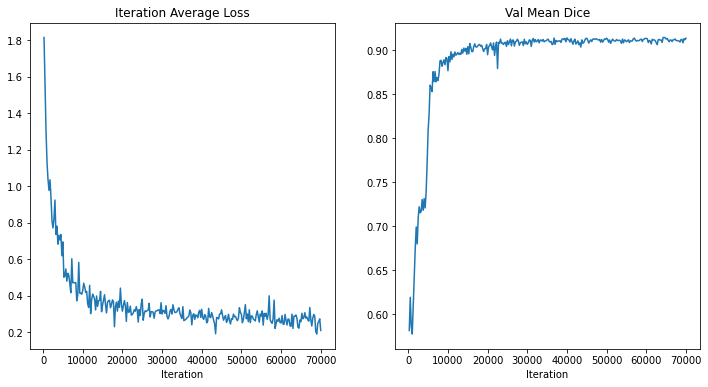

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

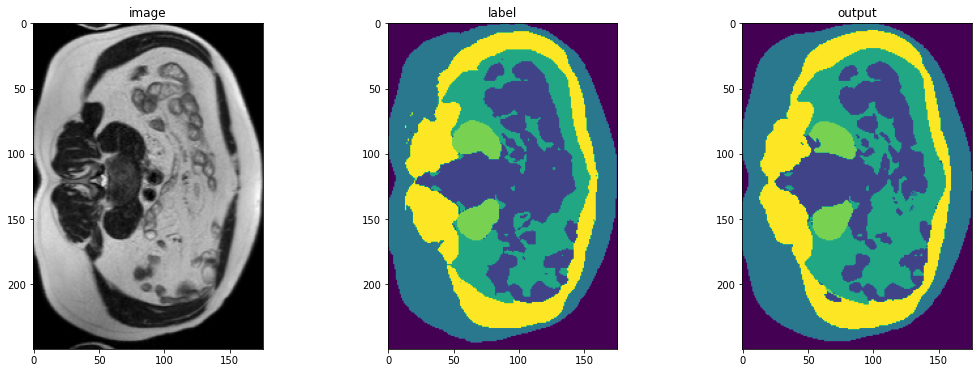

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold2.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [45]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR10swinfold2", output_postfix="seg", resample=False, separate_folder=False),
])

Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


2024-01-16 10:26:27,151 INFO image_writer.py:194 - writing: outMR07_Jan24/A043_v5_T2W_seg.nii.gz


Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


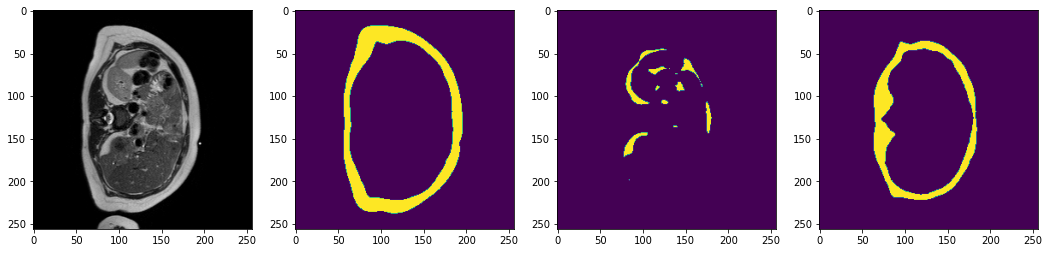

In [47]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR10_swinUNetR_fold2.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [48]:
!tar -cvzf outMR10swinfold2.tar.gz outMR10swinfold2

outMR07_Jan24/
outMR07_Jan24/A026_v1_T2W_seg.nii.gz
outMR07_Jan24/A033_v3_T2W_seg.nii.gz
outMR07_Jan24/A043_v5_T2W_seg.nii.gz
outMR07_Jan24/A051_v2_T2W_seg.nii.gz
outMR07_Jan24/A009_v4_T2W_seg.nii.gz
outMR07_Jan24/A002_v3_T2W_seg.nii.gz
outMR07_Jan24/A029_v4_T2W_seg.nii.gz
outMR07_Jan24/.ipynb_checkpoints/
